# Writing my own version of Variational Quantum Eigensolver

#### Why VQE is important?

Many problems require to find minimum eigenvalue of a matrix. We can use quantum phase estimation for this but due to the hardware limits it remains a fundamental challenge in the current NISQ scenario. VQE presents us a quantum-classical approach to overcome this issue.

### Some important definitions

#### Hamiltonian of the system

Hamiltonian of the system gives the total energy (sum of kinetic energy and potential energy) of the system. It basically describes the energy of the system. It can be derived from the Schrodinger equation.

#### Eigenvalue

## Qunatum Expectation Estimation

The quantum expectation estimation algorithm finds the expectation value of any Hamiltonian ($H$) for any input state $\Psi$

Any Hamiltonian might be written as,

$$ \langle H\rangle = \sum\limits_{i\alpha} h_{\alpha}^i \langle\sigma_{\alpha}^i\rangle + \sum\limits_{ij\alpha\beta} h_{\alpha\beta}^{ij} \langle\sigma_{\alpha}^{i}\sigma_{\beta}^{j}\rangle + \dots$$

where, $i$,$j$... identify the subsystem on Hamiltonian act and $\alpha$, $\beta$... are Pauli operator, hence, it can be $x$, $y$, $z$ and $i$

For example, for one qubit system,


$$\langle H\rangle=\langle \psi|H|\psi\rangle=a\cdot\langle\psi|I|\psi\rangle+b\cdot\langle\psi|Z|\psi\rangle +c\cdot\langle\psi|Y|\psi\rangle + +d\cdot\langle\psi|X|\psi\rangle$$

Thus, the evaluation of $\langle H \rangle$reduces to the sum of a polynomial number of expectation values of simple Pauli operators for a quantum state $\psi$, multiplied by some real constants. A quantum device can efficiently evaluate the expectation value of a tensor product of an arbitrary number of simple Pauli operators. Therefore, with an n-qubit state we can efficiently evaluate the expectation value of this $2^n \times 2^n$
Hamiltonian.

The coherence time for measurement of each state in VQE is $O(1)$ (an advantage over QPE) where as the disadvantage is number state preparation is increased and the precision is also affected.

In essence, QEE dramatically reduce the coherence time requirement while maintaining an exponential advantage over
the classical case, by adding a polynomial number of repetitions with respect to QPE. 

### VQE

#### Mathematics associated

Relation between eigenvectors $|\psi\rangle$ and eigenvalues $\lambda$ can be given by,

$$H|\psi\rangle = \lambda \psi$$

The eigenvector $|\psi\rangle$ corresponding to the lowest eigenvalue is the $|\psi\rangle$ that minimizes,

$$\frac{\langle \psi|H|\psi\rangle}{\langle \psi|\psi\rangle}$$

Or we can also say,

$$\langle \psi|H|\psi\rangle>=E_0$$

This simply means that $E_{0}$ is the lowest energy eigenstate (ground state) of $H$.

#### Variational form

The algorithm basically goes over every state $|\psi\rangle$ and checks which one of them has the minimum expectation value so that we can find out our lowest eigenvalue. For checking every state we have to create a parametrized circuit (anstanz) that covers each and every possible state. Picking a 'good' anstanz from all possible is an art. The circuit should be created such that it doesn't have many parameters and gates (should be shallow).

#### Parameter optimization

Now the easy classical work where you have to optimize your parameters for giving you the minimum expectation value. You can use any prebuilt classical optimizer for it or even create your own. 

## Let us dive into implementing Portfolio optimization from scratch

### What is Portfolio Optimization?
We are using mean-variance portfolio optimization technique.

#### Mean-Variance Analysis

According to the [Investopedia](https://www.investopedia.com/terms/m/meanvariance-analysis.asp):

Mean-variance analysis is the process of weighing risk, expressed as variance, against expected return. Investors use mean-variance analysis to make decisions about which financial instruments to invest in, based on how much risk they are willing to take on in exchange for different levels of reward. Mean-variance analysis allows investors to find the biggest reward at a given level of risk.

## Let us dive into implementing Portfolio optimization from scratch

### The first thing we will do is create a cost function which we want to minimize, we will map it into an Ising Hamiltonian. 


Import the libraries

In [1]:
from qiskit.finance.data_providers import RandomDataProvider

import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from nsepy import get_history

from docplex.mp.model import Model
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import LinearEqualityToPenalty
from qiskit.aqua.algorithms import NumPyMinimumEigensolver

import pennylane as qml

I picked three random assets from Indian Stock Market NSE

In [84]:
assets = [ 'INFY', 'TCS', 'YESBANK']
stockStartDate = datetime.date(2018,8,20)
stockEndDate = datetime.date(2019,8,20)

df = pd.DataFrame()

for stock in assets:
    df[stock] = get_history(symbol=stock, start=stockStartDate, end=stockEndDate)['Close']
    
returns = df.pct_change()
cov_matrix_annual = returns.cov() * 249

mu = returns.mean().to_numpy()     #expected returns
sigma = cov_matrix_annual.to_numpy()  #covariance

#### Creating the Quadratic program for the following equation

max: $  \mu^T x - qx^T \sum x$

Subject to: $ 1^T x= B$

#### where we use the following notation:

* x∈{0,1}$^n$  denotes the vector of binary decision variables, which indicate which assets to pick (x[i]=1) and which not to pick (x[i]=0),

* $\mu ∈ R^n$ defines the expected returns for the assets,

* $\sum ∈ R^{n×n}$ specifies the covariances between the assets,

* $q>0$ controls the risk appetite of the decision maker,

* and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications: - all assets have the same price (normalized to 1), - the full budget $B$ has to be spent, i.e. one has to select exactly $B$ assets.

In [85]:
q = 0.1                  # set risk factor
budget = 2       # set budget
penalty = num_assets      # set parameter to scale the budget penalty term

mdl = Model('docplex model')
x = mdl.binary_var_list(num_assets)

# set objective function: 
#
#     maximize { mu^T * x - q * x^T * sigma * x }
#

objective = mdl.sum([mu[i] * x[i] for i in range(num_assets)])  # mu^T * x
objective -= q * mdl.sum([sigma[i][j]*x[i]*x[j] for i in range(num_assets) for j in range(num_assets)])
mdl.maximize(objective)

# add budget constraint: 
#
#     1^T * x == budget
#
cost = mdl.sum([x[i] for i in range(num_assets)])
mdl.add_constraint(cost == budget, ctname='budget')
    

# converting to Quadratic Program
mod = QuadraticProgram()        
mod.from_docplex(mdl)

#removing the constraint to create the QUBO
lineq2penalty = LinearEqualityToPenalty(penalty) 
qubo = lineq2penalty.convert(mod)

#converting QUBO to an Ising Hamiltonian
H, offset = qubo.to_ising()
H.num_qubits

3

In [86]:
H = H.to_legacy_op()

In [87]:
H.print_details()

'IIZ\t(1.4836080159591571+0j)\nIZI\t(1.4967393480408977+0j)\nZII\t(1.4641348464434452+0j)\nIZZ\t(1.5009745648914863+0j)\nZIZ\t(1.4998570244690541+0j)\nZZI\t(1.4995262792878843+0j)\n'

Defining a 2 layer `ansatz` with 9 parameters

In [94]:
def ansatz(theta):
    
    qml.RX(theta[0], wires=0)
    qml.RX(theta[1], wires=1)
    qml.RX(theta[2], wires=2)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0,2])
    qml.CNOT(wires=[1,2])
    qml.RX(theta[3], wires=0)
    qml.RX(theta[4], wires=1)
    qml.RX(theta[5], wires=2)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0,2])
    qml.CNOT(wires=[1,2])
    qml.RX(theta[6], wires=0)
    qml.RX(theta[7], wires=1)
    qml.RX(theta[8], wires=2)
    
    return ansatz

dev1 = qml.device("qiskit.aer", wires=3)

Functions for returning the `expectation value` in a `particular basis`

In [89]:
@qml.qnode(dev1)
def circuit_IIZ(params):
    ansatz(params)
    return qml.expval(qml.Identity(0)@qml.Identity(1)@qml.PauliZ(2))

@qml.qnode(dev1)
def circuit_IZI(params):
    ansatz(params)
    return qml.expval(qml.Identity(0)@qml.PauliZ(1)@qml.Identity(2))

@qml.qnode(dev1)
def circuit_ZII(params):
    ansatz(params)
    return qml.expval(qml.PauliZ(0)@qml.Identity(1)@qml.Identity(2))

@qml.qnode(dev1)
def circuit_IZZ(params):
    ansatz(params)
    return qml.expval(qml.Identity(0)@qml.PauliZ(1)@qml.PauliZ(2))

@qml.qnode(dev1)
def circuit_ZIZ(params):
    ansatz(params)
    return qml.expval(qml.PauliZ(0)@qml.Identity(1)@qml.PauliZ(2))

@qml.qnode(dev1)
def circuit_ZZI(params):
    ansatz(params)
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1)@qml.Identity(2))


Change the `Hamiltonian` into a `dictionary` form just for the ease

In [90]:
def pauli_operator_to_dict(pauli_operator):
    
    d = pauli_operator.to_dict()
    paulis = d['paulis']
    paulis_dict = {}

    for x in paulis:
        label = x['label']
        coeff = x['coeff']['real']
        paulis_dict[label] = coeff

    return paulis_dict

pauli_dict = pauli_operator_to_dict(H)

Now we define our final function `VQE` (our objective function). We want to maximize this function.

In [91]:
def vqe(parameters):
    
    expval_ZII = pauli_dict['ZII'] * circuit_ZII(parameters)  
    expval_IIZ = pauli_dict['IIZ'] * circuit_IIZ(parameters)
    expval_IZI = pauli_dict['IZI'] * circuit_IZI(parameters)
    expval_ZZI = pauli_dict['ZZI'] * circuit_ZZI(parameters)
    expval_ZIZ = pauli_dict['ZIZ'] * circuit_ZIZ(parameters)
    expval_IZZ = pauli_dict['IZZ'] * circuit_IZZ(parameters)
    
    # summing the measurement results
    classical_adder = expval_ZII + expval_IIZ + expval_ZIZ +  expval_ZZI + expval_ZIZ + expval_IZZ
    
    return classical_adder

Run optimization using `Gradient Descent` 

<BarContainer object of 8 artists>

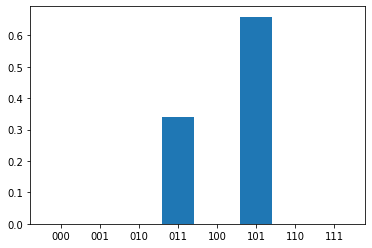

In [97]:
opt = qml.GradientDescentOptimizer(stepsize=0.5)
value = []
    # optimize parameters in objective
params = np.random.rand(9)*2
init_params = params
steps = 100
for i in range(steps):
    params = opt.step(vqe, params)
    value.append(vqe(params))
    
plt.bar(['000', '001', '010', '011', '100', '101', '110', '111'], final_circ(params))

Create the final circuit

In [39]:
@qml.qnode(dev1)
def final_circ(params):
    ansatz(params)
    return qml.probs(wires=[0,1,2])

In [49]:
params

array([-3.14159265e+00, -1.33407091e-01, -6.60037790e-01, -6.19521602e-17,
       -7.50574652e-17, -1.83896694e+00, -5.72904050e-18,  1.33407091e-01,
        7.13382634e-01])

Plot the results

<BarContainer object of 8 artists>

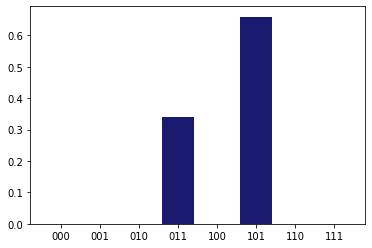

In [107]:
plt.bar(['000', '001', '010', '011', '100', '101', '110', '111'], final_circ(params), color='midnightblue')

Result from classical eigensolver

Voila! We have successfully implemented VQE for portfolio optimization

In [100]:
 pauli_dict

{'IIZ': 1.4836080159591571,
 'IZI': 1.4967393480408977,
 'ZII': 1.4641348464434452,
 'IZZ': 1.5009745648914863,
 'ZIZ': 1.4998570244690541,
 'ZZI': 1.4995262792878843}

In [101]:
H.print_details()

'IIZ\t(1.4836080159591571+0j)\nIZI\t(1.4967393480408977+0j)\nZII\t(1.4641348464434452+0j)\nIZZ\t(1.5009745648914863+0j)\nZIZ\t(1.4998570244690541+0j)\nZZI\t(1.4995262792878843+0j)\n'

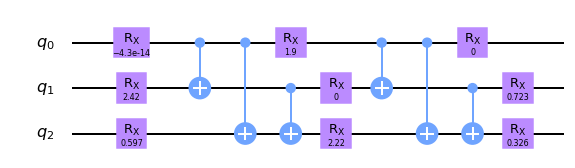

In [105]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(3)
circ.rx(params[0], 0)
circ.rx(params[1], 1)
circ.rx(params[2], 2)
circ.cx(0,1)
circ.cx(0,2)
circ.cx(1,2)
circ.rx(params[3], 0)
circ.rx(params[4], 1)
circ.rx(params[5], 2)
circ.cx(0,1)
circ.cx(0,2)
circ.cx(1,2)
circ.rx(params[6], 0)
circ.rx(params[7], 1)
circ.rx(params[8], 2)

circ.draw('mpl')